# Comparing Model Robustness to Adversarial Attacks

In this notebook, we'll compare how different neural network architectures respond to adversarial attacks. We'll evaluate several popular pre-trained models from the torchvision library and measure their robustness against both untargeted and targeted attacks.

## Objectives

1. Compare the robustness of different model architectures (ResNet, VGG, MobileNet, Inception)
2. Measure how much perturbation is needed to fool each model
3. Evaluate the transferability of adversarial examples between models
4. Identify which model architectures are most resistant to adversarial attacks

In [1]:
%load_ext autoreload
%autoreload 2

# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
from tqdm import tqdm

# Import our utility functions
import sys
sys.path.append('../')
from src.models import load_pretrained_model, predict, get_imagenet_label,get_imagenet_index
from src.utils import load_image, preprocess_image, deprocess_tensor, compute_metrics
from src.adversarial_attacks import fgsm_attack, pgd_attack, deepfool_attack,cw_attack

## Step 1: Load Multiple Pretrained Models

In [2]:
# Load different models
print("Loading models...")
models = {
    'ResNet-50': load_pretrained_model('resnet50'),
    'VGG16': load_pretrained_model('vgg16'),
    'MobileNetV2': load_pretrained_model('mobilenet_v2'),
    'Inception-v3': load_pretrained_model('inception_v3')
}
print("Models loaded successfully!")

Loading models...


/home/coohrentiin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/coohrentiin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/coohrentiin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`.

Models loaded successfully!


## Step 2: Load and Preprocess Test Images

We'll use a set of sample images to test the models' robustness.

Found 7 sample images: cat.jpg, dog.jpg, bird.jpg, car.jpg, ship.jpg, schoolbus.jpg, poodle2.jpg


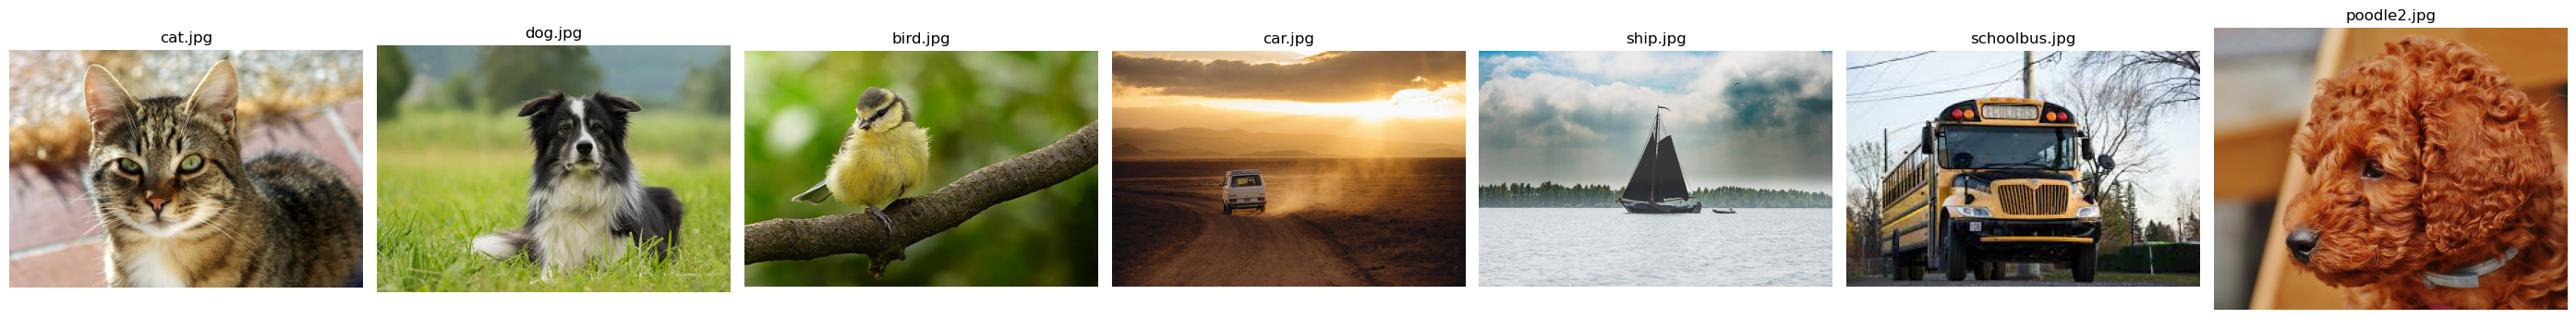

In [3]:
# Create a directory for sample images if it doesn't exist
sample_dir = '../data/sample_images/'
os.makedirs(sample_dir, exist_ok=True)

# List sample images (you'll need to add these to the directory)
sample_images = [
    'cat.jpg',
    'dog.jpg',
    'bird.jpg',
    'car.jpg',
    'ship.jpg',
    "schoolbus.jpg",
    "poodle2.jpg",
]

# Check which images exist
existing_images = [img for img in sample_images if os.path.exists(os.path.join(sample_dir, img))]

if not existing_images:
    print(f"Please add some sample images to {sample_dir}")
    print("You can use images like: cat.jpg, dog.jpg, bird.jpg, car.jpg, ship.jpg")
else:
    print(f"Found {len(existing_images)} sample images: {', '.join(existing_images)}")

    # Load and preprocess images
    images = []
    original_pils = []
    for img_name in existing_images:
        img_path = os.path.join(sample_dir, img_name)
        pil_img = load_image(img_path)
        tensor_img = preprocess_image(pil_img)
        images.append(tensor_img)
        original_pils.append(pil_img)
    
    # Display the images
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 4))
    if num_images == 1:
        axes = [axes]
    
    for i, (img, name) in enumerate(zip(original_pils, existing_images)):
        axes[i].imshow(img)
        axes[i].set_title(name)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## Step 3: Test Baseline Model Accuracy

Let's first test how accurate the models are on the original (unmodified) images.

In [4]:
# Test each model on each image
predicted_labels = []
# base_model = 'ResNet-50'

if existing_images:
    results = {model_name: [] for model_name in models.keys()}
    
    print("Baseline model predictions on original images:")
    print("-" * 50)
    
    for i, (img_tensor, img_name) in enumerate(zip(images, existing_images)):
        print(f"Image: {img_name}")
        
        for model_name, model in models.items():
            idx, class_idx, conf = predict(model, img_tensor)
            results[model_name].append((idx, class_idx, conf))
            print(f"  {model_name}: {class_idx} with {conf:.2%} confidence")
        
        # Get the predicted label
        predicted_label = get_imagenet_label(idx)
        predicted_labels.append(predicted_label)
        print()
print(predicted_labels)

Baseline model predictions on original images:
--------------------------------------------------
Image: cat.jpg
  ResNet-50: tabby cat with 54.51% confidence
  VGG16: tabby cat with 54.84% confidence
  MobileNetV2: Egyptian Mau with 36.63% confidence
  Inception-v3: tiger cat with 85.14% confidence

Image: dog.jpg
  ResNet-50: Border Collie with 84.08% confidence
  VGG16: Border Collie with 71.12% confidence
  MobileNetV2: Border Collie with 64.39% confidence
  Inception-v3: Border Collie with 90.57% confidence

Image: bird.jpg
  ResNet-50: goldfinch with 83.48% confidence
  VGG16: goldfinch with 42.15% confidence
  MobileNetV2: goldfinch with 79.64% confidence
  Inception-v3: goldfinch with 99.72% confidence

Image: car.jpg
  ResNet-50: jeep with 96.97% confidence
  VGG16: jeep with 64.07% confidence
  MobileNetV2: jeep with 81.15% confidence
  Inception-v3: jeep with 96.89% confidence

Image: ship.jpg
  ResNet-50: yawl with 39.49% confidence
  VGG16: catamaran with 54.84% confidence

## Step 4: Illustration of Adversarial Attack
### FGSM

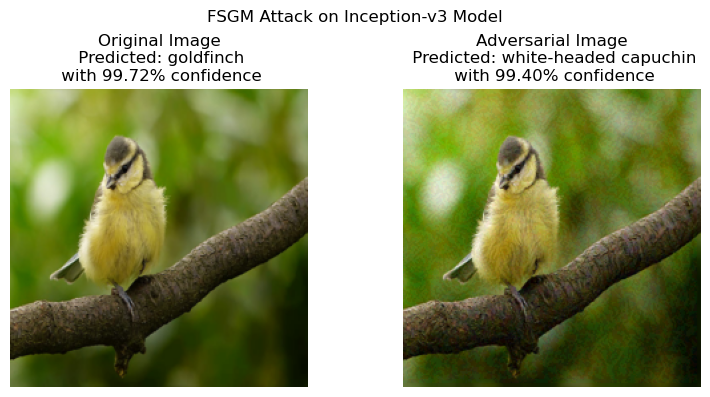

In [18]:
img_tensor = images[2].clone()
orig_idx, orig_class, orig_conf = predict(model, img_tensor)
attack_fn = fgsm_attack
adv_tensor = attack_fn(model, img_tensor.clone(), target=get_imagenet_index("capuchin"),epsilon=0.1)
adv_idx, adv_class, adv_conf = predict(model, adv_tensor)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(deprocess_tensor(img_tensor))
plt.title(f"Original Image\n Predicted: {orig_class}\n with {orig_conf:.2%} confidence")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(deprocess_tensor(adv_tensor))
plt.title(f"Adversarial Image\n Predicted: {adv_class}\n with {adv_conf:.2%} confidence")
plt.axis('off')
plt.suptitle(f"FSGM Attack on {model_name} Model")
plt.tight_layout()
plt.savefig(f"fgsm_attack_{model_name}.png", dpi=300)
plt.show()

### PGD

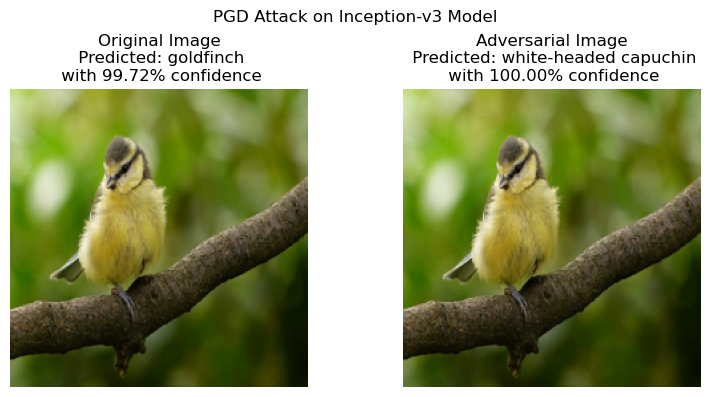

In [19]:
img_tensor = images[2].clone()
orig_idx, orig_class, orig_conf = predict(model, img_tensor)
attack_fn = pgd_attack
adv_tensor = attack_fn(model, img_tensor.clone(), target=get_imagenet_index("capuchin"))
adv_idx, adv_class, adv_conf = predict(model, adv_tensor)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(deprocess_tensor(img_tensor))
plt.title(f"Original Image\n Predicted: {orig_class}\n with {orig_conf:.2%} confidence")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(deprocess_tensor(adv_tensor))
plt.title(f"Adversarial Image\n Predicted: {adv_class}\n with {adv_conf:.2%} confidence")
plt.axis('off')
plt.suptitle(f"PGD Attack on {model_name} Model")
plt.tight_layout()
plt.savefig('pgd_attack.png', dpi=300)
plt.show()

### DeepFool

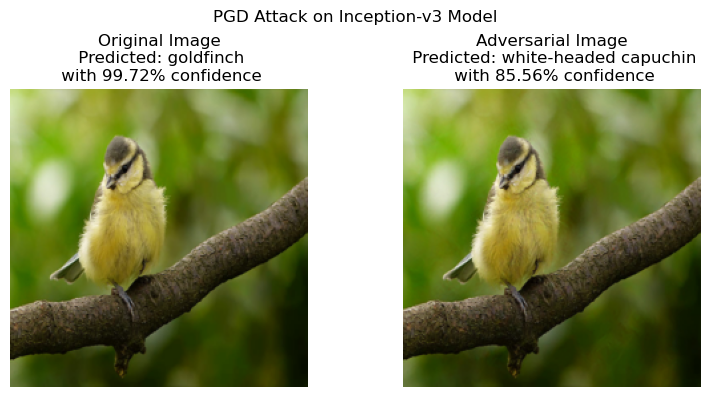

In [34]:
img_tensor = images[2].clone()
orig_idx, orig_class, orig_conf = predict(model, img_tensor)
attack_fn = deepfool_attack
adv_tensor = attack_fn(model, img_tensor.clone(),overshoot=0.1,max_iterations=100)
adv_idx, adv_class, adv_conf = predict(model, adv_tensor)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(deprocess_tensor(img_tensor))
plt.title(f"Original Image\n Predicted: {orig_class}\n with {orig_conf:.2%} confidence")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(deprocess_tensor(adv_tensor))
plt.title(f"Adversarial Image\n Predicted: {adv_class}\n with {adv_conf:.2%} confidence")
plt.axis('off')
plt.suptitle(f"PGD Attack on {model_name} Model")
plt.tight_layout()
plt.savefig('pgd_attack.png', dpi=300)
plt.show()

### C&W

100%|██████████| 9/9 [00:20<00:00,  2.26s/it]


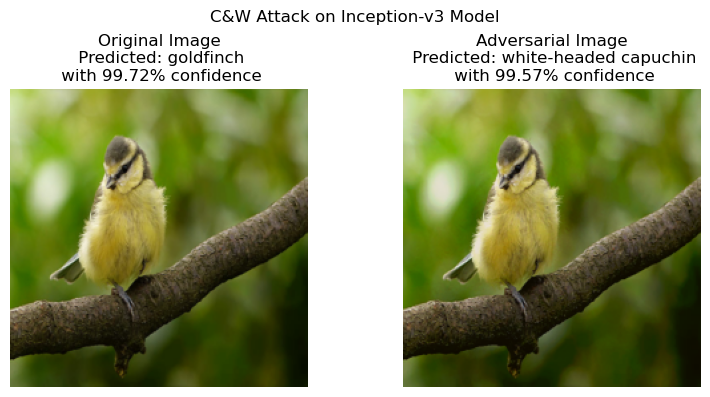

In [24]:
img_tensor = images[2].clone()
orig_idx, orig_class, orig_conf = predict(model, img_tensor)
attack_fn = cw_attack
adv_tensor = attack_fn(model, img_tensor.clone(), target=get_imagenet_index("capuchin"),
                       learning_rate=0.05, c=0.1)
adv_idx, adv_class, adv_conf = predict(model, adv_tensor)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(deprocess_tensor(img_tensor))
plt.title(f"Original Image\n Predicted: {orig_class}\n with {orig_conf:.2%} confidence")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(deprocess_tensor(adv_tensor))
plt.title(f"Adversarial Image\n Predicted: {adv_class}\n with {adv_conf:.2%} confidence")
plt.axis('off')
plt.suptitle(f"C&W Attack on {model_name} Model")
plt.tight_layout()
plt.savefig('cw_attack.png', dpi=300)
plt.show()

## Step 5: Generate an example that get miss classified after taking a picture 

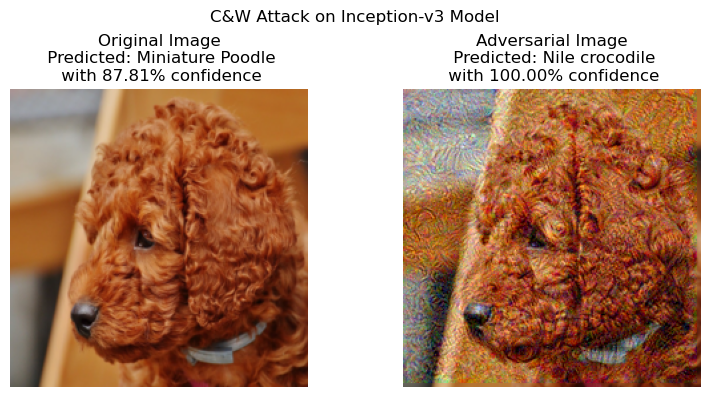

In [115]:
img_tensor = images[-1].clone()
orig_idx, orig_class, orig_conf = predict(model, img_tensor)
# attack_fn = 
adv_tensor = pgd_attack(model, img_tensor.clone(),
                    #    target=get_imagenet_index('catcher'),
                       target=get_imagenet_index('crocodile'),
                       alpha=0.04,
                       iterations=100)
adv_idx, adv_class, adv_conf = predict(model, adv_tensor)
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(deprocess_tensor(img_tensor))
plt.title(f"Original Image\n Predicted: {orig_class}\n with {orig_conf:.2%} confidence")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(deprocess_tensor(adv_tensor))
plt.title(f"Adversarial Image\n Predicted: {adv_class}\n with {adv_conf:.2%} confidence")
plt.axis('off')
plt.suptitle(f"C&W Attack on {model_name} Model")
plt.tight_layout()
# plt.savefig('cw_attack_strong_collie.pdf', dpi=300)
plt.savefig('cw_attack_strong_poodle.pdf', dpi=300)
plt.show()

Pred class: oystercatcher with 100.00% confidence


(-0.5, 223.5, 223.5, -0.5)

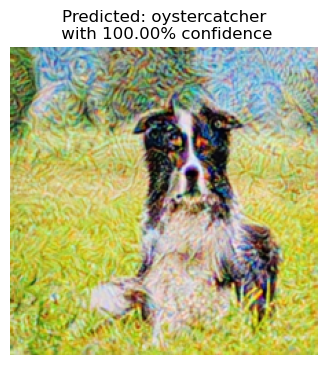

In [ ]:
# img_name = "collie_pic_.jpg"
img_name = "collie_screen_pic_.jpg"
# img_name = "poodle_screen_pic_.jpg"
img_path = os.path.join(sample_dir, img_name)
pil_img = load_image(img_path)
tensor_img = preprocess_image(pil_img)
adv_idx, adv_class, adv_conf = predict(model, tensor_img)
print(f"Pred class: {adv_class} with {adv_conf:.2%} confidence")

plt.figure(figsize=(8, 4))
plt.imshow(deprocess_tensor(tensor_img))
plt.title(f"Predicted: {adv_class}\n with {adv_conf:.2%} confidence")
# plt.savefig(f"collie_screen_pic_adv.pdf", dpi=300)
# plt.savefig(f"poodle_screen_pic_adv.pdf", dpi=300)
plt.axis('off')


## Analyse Performances 

In [36]:
import lpips


def benchmark_attacks(models, images, attacks, true_labels, device="cuda"):
    """
    Benchmark different adversarial attacks across models and images.
    
    Args:
        models (dict): Model name -> model
        images (list): List of [1, 3, 224, 224] tensors
        attacks (dict): Attack name -> attack function
        true_labels (list): True labels corresponding to images
        device (str): 'cuda' or 'cpu'
        
    Returns:
        results (list of dict): One entry per (model, attack) combination
    """
    results = []
    loss_fn_lpips = lpips.LPIPS(net='alex').to(device)
    for model_name, model in models.items():
        model = model.to(device)
        model.eval()
        
        for attack_name, attack_fn in attacks.items():
            n_images = len(images)
            n_success = 0
            l2_norms = []
            linf_norms = []
            lpips_norms = []
            wrong_confidences = []
            total_time = 0
            
            for img_idx, image in enumerate(tqdm(images, desc=f"{model_name} - {attack_name}")):
                image = image.clone().to(device)
                true_label = true_labels[img_idx]
                
                # Predict clean
                pred_idx, pred_label, pred_conf = predict(model,image.clone())
                
                # Skip if already wrong
                if pred_label != true_label:
                    continue

                # Attack
                start_time = time.time()
                adv_image = attack_fn(model, image.clone())
                end_time = time.time()
                total_time += (end_time - start_time)
                
                # Predict adversarial
                adv_idx, adv_label, adv_conf = predict(model,adv_image.clone())
                
                # Success?
                if adv_idx != pred_idx:
                    n_success += 1
                    # Certainty in wrong prediction
                    wrong_confidences.append(adv_conf)
                    
                    # Perturbation
                    perturbation = adv_image - image
                    l2_norm = torch.mean(perturbation**2).item()**0.5
                    linf_norm = torch.max(torch.abs(perturbation)).item()
                    lpips_norm = loss_fn_lpips(adv_image.to(device), image.to(device)).item()
                    # print(f"L2 norm: {l2_norm:.4f}, Linf norm: {linf_norm:.4f}, LPIPS: {lpips_norm:.4f}")
                    l2_norms.append(l2_norm)
                    linf_norms.append(linf_norm)
                    lpips_norms.append(lpips_norm)
            
            if n_success > 0:
                avg_certainty_wrong = 100 * np.mean(wrong_confidences)
                avg_l2 = np.mean(l2_norms)
                avg_linf = np.mean(linf_norms)
            else:
                avg_certainty_wrong = 0
                avg_l2 = 0
                avg_linf = 0

            results.append({
                "model": model_name,
                "attack": attack_name,
                "success_rate": 100 * n_success / n_images,
                "avg_certainty_wrong": avg_certainty_wrong,
                "avg_l2": avg_l2,
                "avg_linf": avg_linf,
                "avg_time": total_time / n_images
            })
    
    return results

results_benchmark = benchmark_attacks(
    {"Inciption-v3": models["Inception-v3"]},
    images,
    attacks={
        "FGSM": fgsm_attack,
        "PGD": pgd_attack,
        "DeepFool": deepfool_attack,
        "CW": cw_attack
    },
    true_labels=predicted_labels,
    device="cuda"
)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/coohrentiin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/coohrentiin/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/coohrentiin/miniconda3/envs/torch/lib/python3.11/site-packages/lpips/weights/v0.1/alex.pth


Inciption-v3 - CW: 100%|██████████| 7/7 [00:37<00:00,  5.33s/it]


In [37]:
import pandas as pd
pd.DataFrame(results_benchmark)

,model,attack,success_rate,avg_certainty_wrong,avg_l2,avg_linf,avg_time
0,Inciption-v3,FGSM,100.000000,80.694495,0.009866,0.010000,0.088035
1,Inciption-v3,PGD,71.428571,29.146363,0.006140,0.030801,0.958480
2,Inciption-v3,DeepFool,100.000000,77.272952,0.007938,0.131542,0.171044
3,Inciption-v3,CW,100.000000,50.434242,0.120926,0.629255,5.290076


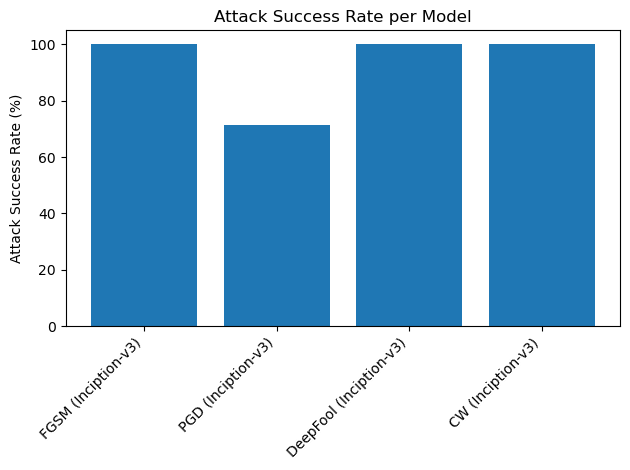

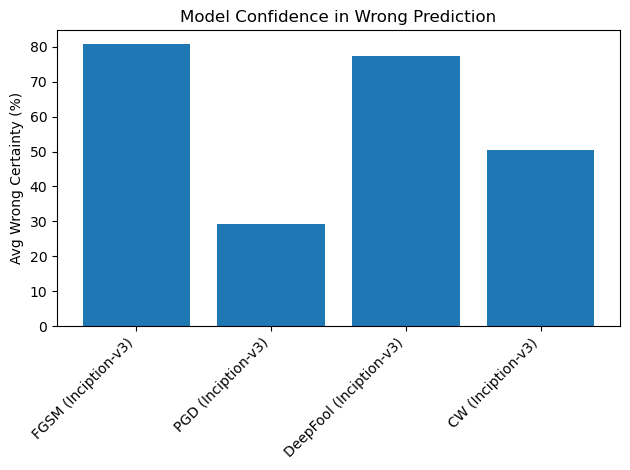

KeyError: 'avg_lpips'

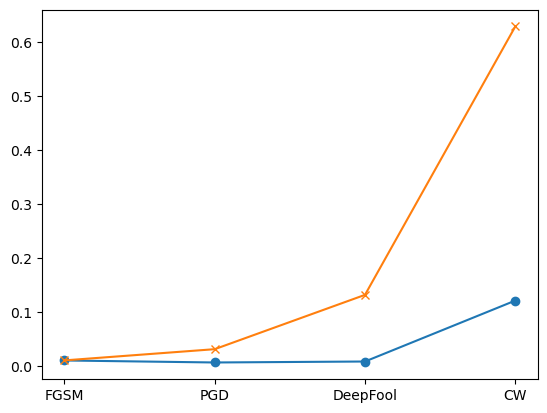

In [38]:
def generate_figures(results):
    """
    Generate useful comparison figures from benchmark results.
    
    Args:
        results (list of dict): Output from benchmark_attacks
    """
    import pandas as pd
    df = pd.DataFrame(results)
    
    # Plot success rates
    plt.figure()
    for model in df['model'].unique():
        subset = df[df['model'] == model]
        plt.bar(subset['attack'] + " (" + model + ")", subset['success_rate'])
    plt.ylabel('Attack Success Rate (%)')
    plt.title('Attack Success Rate per Model')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot wrong certainty
    plt.figure()
    for model in df['model'].unique():
        subset = df[df['model'] == model]
        plt.bar(subset['attack'] + " (" + model + ")", subset['avg_certainty_wrong'])
    plt.ylabel('Avg Wrong Certainty (%)')
    plt.title('Model Confidence in Wrong Prediction')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Plot perturbation norms
    plt.figure()
    for model in df['model'].unique():
        subset = df[df['model'] == model]
        plt.plot(subset['attack'], subset['avg_l2'], marker='o', label=f'{model} - $L_2$ norm')
        plt.plot(subset['attack'], subset['avg_linf'], marker='x', label=f'{model} - $L_\infty$ norm')
        plt.plot(subset['attack'], subset['avg_lpips'], marker='s', label=f'{model} - LPIPS norm')
    plt.ylabel('Perturbation Norm')
    plt.title('Perturbation Size Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot average time
    plt.figure()
    for model in df['model'].unique():
        subset = df[df['model'] == model]
        plt.bar(subset['attack'] + " (" + model + ")", subset['avg_time'])
    plt.ylabel('Avg Time (s)')
    plt.title('Average Time per Attack')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

generate_figures(results_benchmark)

## Conclusion

In this notebook, we've compared the robustness of different neural network architectures against adversarial attacks. Key findings include:

1. **Model Vulnerability**: Different model architectures show varying levels of robustness to adversarial attacks. Some models are consistently more vulnerable than others.

2. **Perturbation Magnitude**: As the epsilon value (perturbation magnitude) increases, all models become more vulnerable to attacks.

3. **Transferability**: Adversarial examples often transfer between models, meaning an example created to fool one model can sometimes fool other models as well. This phenomenon has security implications.

4. **Attack Methods**: PGD attacks are generally more effective than FGSM attacks but require more computational resources. The iterative nature of PGD allows it to find better adversarial examples.

These findings highlight the importance of considering adversarial robustness when deploying neural networks in security-sensitive applications. Model architecture choices can significantly impact vulnerability to adversarial attacks.